The data is available as two attached CSV files:
    
    1. takehome_user_engagement.csv
    2. takehome_users.csv
    
The data has the following two tables:
1. A user table ("takehome_users") with data on 12,000 users who signed up for the
product in the last two years. This table includes:
     * name: the user's name
     * object_id: the user's id
     * email: email address
     * creation_source: how their account was created. This takes on one of 5 values:
         - PERSONAL_PROJECTS: invited to join another user's personal workspace
         - GUEST_INVITE: invited to an organization as a guest(limited permissions)
         - ORG_INVITE: invited to an organization (as a full member)
         - SIGNUP: signed up via the website
         - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

     * creation_time: when they created their account
     * last_session_creation_time: unix timestamp of last login
     * opted_in_to_mailing_list: whether they have opted into receiving marketing emails
     * enabled_for_marketing_drip: whether they are on the regular marketing email drip
     * org_id: the organization (group of users) they belong to
     * invited_by_user_id: which user invited them to join (if applicable).
2. A usage summary table ("takehome_user_engagement") that has a row for each day
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven-day period, ***identify which factors predict future user
adoption***.
We suggest spending 1-2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better ­­ no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt

In [2]:
df_user = pd.read_csv("takehome_users.csv", encoding="latin1")
df_eng = pd.read_csv("takehome_user_engagement.csv")

In [3]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df_eng['weeks'] = pd.to_datetime(df_eng['time_stamp']).dt.week
df_eng.head()

/tmp/ipykernel_12396/3009679154.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_eng['weeks'] = pd.to_datetime(df_eng['time_stamp']).dt.week


,time_stamp,user_id,visited,weeks
0,2014-04-22 03:53:30,1,1,17
1,2013-11-15 03:45:04,2,1,46
2,2013-11-29 03:45:04,2,1,48
3,2013-12-09 03:45:04,2,1,50
4,2013-12-25 03:45:04,2,1,52


In [6]:
df = df_eng.groupby(['weeks', 'user_id'])['time_stamp'].count().reset_index(name="freq")
logs3 = df[df.freq >=3]

In [7]:
logs3

,weeks,user_id,freq
1,1,10,5
2,1,42,4
5,1,63,7
6,1,69,10
7,1,81,3
...,...,...,...
57164,52,11939,5
57165,52,11957,4
57166,52,11959,3
57169,52,11969,3


In [8]:
adopters = logs3["user_id"].unique()
len(adopters)

1445

In [9]:
adopters = pd.DataFrame(adopters, columns= ['user_id'])
adopters.head()

,user_id
0,10
1,42
2,63
3,69
4,81


In [10]:
adopters['adopters'] = 1
adopters['object_id'] = adopters['user_id']
adopter_factors = pd.merge(adopters, df_user, on="object_id", how= "right")
adopter_factors.head()

,user_id,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,NaN,NaN,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,NaN,NaN,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,NaN,NaN,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,NaN,NaN,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
adopter_factors.drop("user_id", axis=1, inplace=True)
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    1445 non-null   float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  object 
 3   name                        12000 non-null  object 
 4   email                       12000 non-null  object 
 5   creation_source             12000 non-null  object 
 6   last_session_creation_time  8823 non-null   float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_id          6417 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


### Handling Missing Values

In [12]:
adopter_factors.isna().sum()

adopters                      10555
object_id                         0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id             5583
dtype: int64

In [13]:
adopter_factors['adopters'] = adopter_factors['adopters'].fillna(0)

In [14]:
adopter_factors['invited_by_user_id'] = adopter_factors['invited_by_user_id'].fillna(0)

In [15]:
adopter_factors

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,0.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,0.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,0.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,0.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,0.0,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0
11997,0.0,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,0.0,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0


In [16]:
adopter_factors.loc[adopter_factors['invited_by_user_id'] != 0, 'invited_by_user_id'] = 1
adopter_factors.head()

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,0.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0
1,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1.0
2,0.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0
3,0.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0
4,0.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0


In [17]:
adopter_factors['last_session_creation_time'] = adopter_factors['last_session_creation_time'].fillna(0)
adopter_factors.isna().sum()

adopters                      0
object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

#### For purposes of modeling, converting the creation_time datetime to a days since value would make more sense. It will be in a more useful format.

In [18]:
adopter_factors['creation_time'] = pd.to_datetime(adopter_factors['creation_time'], infer_datetime_format=True)
adopter_factors['creation_time'] = datetime.now() - adopter_factors['creation_time']
adopter_factors['creation_time'] = adopter_factors['creation_time'].dt.days
adopter_factors

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,0.0,1,3351,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0
1,1.0,2,3509,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1.0
2,0.0,3,3750,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0
3,0.0,4,3687,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0
4,0.0,5,3811,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,11996,3579,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,1.0
11996,0.0,11997,3818,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0
11997,0.0,11998,3346,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,1.0
11998,0.0,11999,4042,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0


#### Checking Correlations

In [19]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    12000 non-null  float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  int64  
 3   name                        12000 non-null  object 
 4   email                       12000 non-null  object 
 5   creation_source             12000 non-null  object 
 6   last_session_creation_time  12000 non-null  float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_id          12000 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


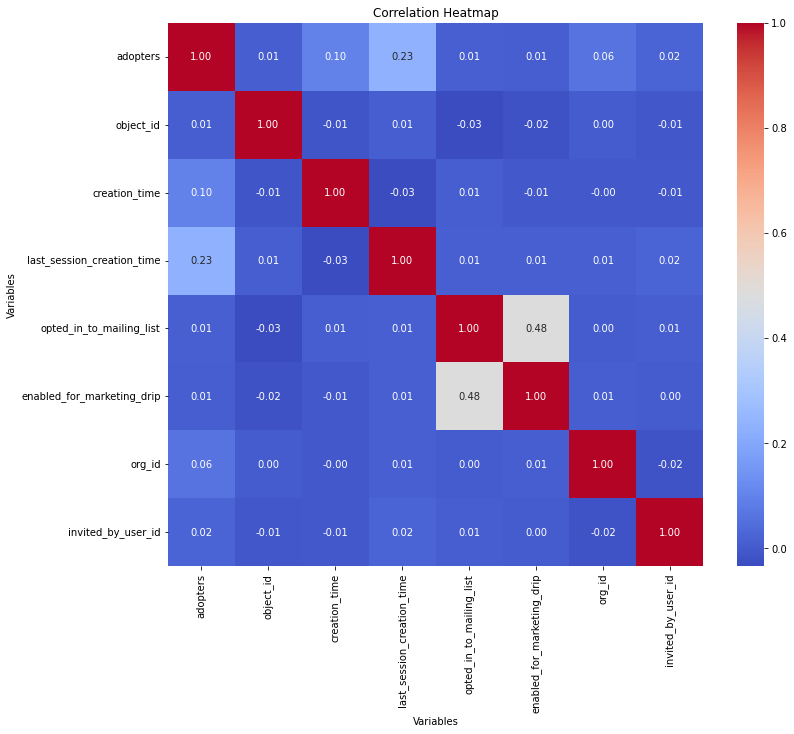

In [20]:
# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(adopter_factors.corr(), annot=True, cmap='coolwarm', fmt='.2f')

# Set plot title and labels
plt.title('Correlation Heatmap')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Display the heatmap
plt.show()

#### 'name' and 'email' do not seem important for this study. Let's delete those columns.

In [21]:
adopter_factors.drop('name', inplace=True, axis=1)
adopter_factors.drop('email', inplace=True, axis=1)

In [22]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    12000 non-null  float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  int64  
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  12000 non-null  float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          12000 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 937.5+ KB


#### One Hot Encoding for the column 'creation_source'

In [23]:
df = pd.get_dummies(adopter_factors)
df['adopters'] = df['adopters'].astype('bool')
df

,adopters,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,False,1,3351,1.398139e+09,1,0,11,1.0,1,0,0,0,0
1,True,2,3509,1.396238e+09,0,0,1,1.0,0,1,0,0,0
2,False,3,3750,1.363735e+09,0,0,94,1.0,0,1,0,0,0
3,False,4,3687,1.369210e+09,0,0,1,1.0,1,0,0,0,0
4,False,5,3811,1.358850e+09,0,0,193,1.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,False,11996,3579,1.378448e+09,0,0,89,1.0,0,1,0,0,0
11996,False,11997,3818,1.358275e+09,0,0,200,0.0,0,0,0,0,1
11997,False,11998,3346,1.398603e+09,1,1,83,1.0,1,0,0,0,0
11998,False,11999,4042,1.338638e+09,0,0,6,0.0,0,0,1,0,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   adopters                            12000 non-null  bool   
 1   object_id                           12000 non-null  int64  
 2   creation_time                       12000 non-null  int64  
 3   last_session_creation_time          12000 non-null  float64
 4   opted_in_to_mailing_list            12000 non-null  int64  
 5   enabled_for_marketing_drip          12000 non-null  int64  
 6   org_id                              12000 non-null  int64  
 7   invited_by_user_id                  12000 non-null  float64
 8   creation_source_GUEST_INVITE        12000 non-null  uint8  
 9   creation_source_ORG_INVITE          12000 non-null  uint8  
 10  creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 11  creation_source_SIGNUP              12000

#### Training Model

In [25]:
X = df.drop(columns = ['adopters','last_session_creation_time'], axis=1)
y = df['adopters']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#### Simple Logistic Regression

In [26]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

#### Model Evaluation

In [27]:
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      8433
        True       0.12      1.00      0.22      1167

    accuracy                           0.12      9600
   macro avg       0.06      0.50      0.11      9600
weighted avg       0.01      0.12      0.03      9600



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

In [28]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2122
        True       0.12      1.00      0.21       278

    accuracy                           0.12      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.12      0.02      2400



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

#### Finding Best Model

In [29]:
rf = RandomForestClassifier(random_state = 10)

# Create param grid.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create grid search object

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit on data

best = rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  21.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  14.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  12.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=  19.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimat

/home/rana/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  20.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  16.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   8.0s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   4.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  19.4s
[CV] END bootstrap=False, max_depth=80

In [30]:
best.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [31]:
best.best_score_

0.8784374999999999

#### Model Evaluation

In [32]:
y_pred = best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      8433
        True       0.00      0.00      0.00      1167

    accuracy                           0.88      9600
   macro avg       0.44      0.50      0.47      9600
weighted avg       0.77      0.88      0.82      9600



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      2122
        True       0.00      0.00      0.00       278

    accuracy                           0.88      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.78      0.88      0.83      2400



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(best)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)


#### Gradient Boost

In [35]:
param_grid = dict(
    learning_rate=[0.001, 0.05, 0.1, 0.2, 0.5],
    max_depth=list(range(2,4)),
    min_samples_leaf=list(range(1,21)),
    min_samples_split=list(range(5,51)),
)
gb = GradientBoostingClassifier(n_estimators=50, max_features=2, 
                                random_state = 10)
gb_cv = RandomizedSearchCV(gb, param_grid, scoring='f1', cv=5, n_iter = 20)
gb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(max_features=2,
                                                        n_estimators=50,
                                                        random_state=10),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.001, 0.05, 0.1, 0.2,
                                                          0.5],
                                        'max_depth': [2, 3],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20],
                                        'min_samples_split': [5, 6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                             

In [36]:
gb_cv.best_params_

{'min_samples_split': 33,
 'min_samples_leaf': 4,
 'max_depth': 3,
 'learning_rate': 0.5}

In [37]:
y_pred = gb_cv.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      8433
        True       0.83      0.02      0.04      1167

    accuracy                           0.88      9600
   macro avg       0.85      0.51      0.49      9600
weighted avg       0.87      0.88      0.83      9600



In [38]:
y_pred = gb_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94      2122
        True       0.00      0.00      0.00       278

    accuracy                           0.88      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.78      0.88      0.83      2400

